In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
import numpy as np
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [28]:
data = pd.read_csv("/content/dataset.csv")
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [29]:
data.shape

(10999, 12)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [31]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [32]:
label_map={}
for i in data.columns:
  if str(data[i].dtype) == 'object':
      temp={}
      cats=data[i].unique()
      for index in range(len(cats)):
           temp[cats[index]]=index
      label_map[i]=temp
      #Labeling
      data[i]=data[i].map(temp)
label_map

{'Warehouse_block': {'D': 0, 'F': 1, 'A': 2, 'B': 3, 'C': 4},
 'Mode_of_Shipment': {'Flight': 0, 'Ship': 1, 'Road': 2},
 'Product_importance': {'low': 0, 'medium': 1, 'high': 2},
 'Gender': {'F': 0, 'M': 1}}

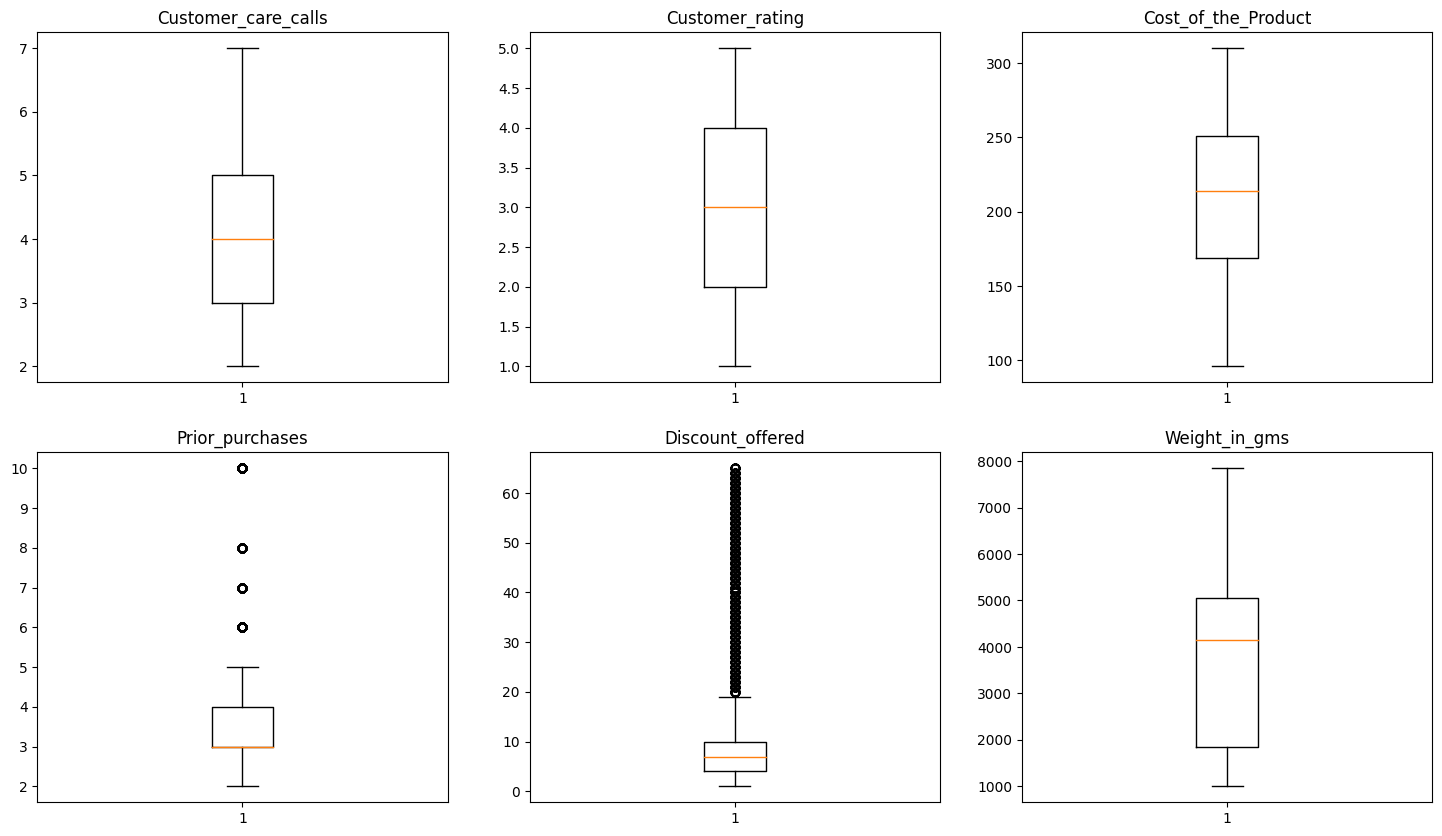

In [33]:
c=0
plt.figure(figsize=(18, 10))
for i in data.drop(columns=[
                            'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender','Reached.on.Time_Y.N','ID'
                           ]).columns:
      if str(data[i].dtype)=="object ":
            continue
      plt.subplot(2, 3, c+1)
      plt.boxplot(data[i])
      plt.title(i)
      c+=1
plt.show()

In [34]:
def check_outliers (arr):
        Q1= np.percentile(arr, 25, interpolation = 'midpoint')
        Q3= np.percentile(arr, 75, interpolation = 'midpoint')
        IQR = Q3 - Q1

        #Above Upper bound
        upper=Q3+1.5*IQR
        upper_array=np.array(arr>=upper)
        print(' '*3,len(upper_array[upper_array == True]), 'are over the upper bound:',upper)
        #BeLow Lower bound
        lower=Q1-1.5*IQR
        lower_array=np.array(arr<=lower)
        print(' '*3,len(lower_array[lower_array == True]), 'are less than the lower bound:', lower, '\n')
for i in data.drop(columns=[
                            'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N','ID'
                           ]).columns:
        if str(data[i].dtype)=='object':
            continue
        print(i)
        check_outliers(data[i])

Customer_care_calls
    0 are over the upper bound: 8.0
    0 are less than the lower bound: 0.0 

Customer_rating
    0 are over the upper bound: 7.0
    0 are less than the lower bound: -1.0 

Cost_of_the_Product
    0 are over the upper bound: 374.0
    0 are less than the lower bound: 46.0 

Prior_purchases
    1003 are over the upper bound: 5.5
    0 are less than the lower bound: 1.5 

Discount_offered
    2262 are over the upper bound: 19.0
    0 are less than the lower bound: -5.0 

Weight_in_gms
    0 are over the upper bound: 9865.75
    0 are less than the lower bound: -2976.25 



<ipython-input-34-b5d63727f3e6>:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1= np.percentile(arr, 25, interpolation = 'midpoint')
<ipython-input-34-b5d63727f3e6>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3= np.percentile(arr, 75, interpolation = 'midpoint')


In [35]:
data.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,1.833167,0.998454,4.054459,2.990545,210.196836,3.567597,0.604600,0.495863,13.373216,3634.016729,0.596691
std,3175.28214,1.343823,0.567099,1.141490,1.413603,48.063272,1.522860,0.641464,0.500006,16.205527,1635.377251,0.490584
min,1.00000,0.000000,0.000000,2.000000,1.000000,96.000000,2.000000,0.000000,0.000000,1.000000,1001.000000,0.000000
25%,2750.50000,1.000000,1.000000,3.000000,2.000000,169.000000,3.000000,0.000000,0.000000,4.000000,1839.500000,0.000000
50%,5500.00000,1.000000,1.000000,4.000000,3.000000,214.000000,3.000000,1.000000,0.000000,7.000000,4149.000000,1.000000
75%,8249.50000,3.000000,1.000000,5.000000,4.000000,251.000000,4.000000,1.000000,1.000000,10.000000,5050.000000,1.000000
max,10999.00000,4.000000,2.000000,7.000000,5.000000,310.000000,10.000000,2.000000,1.000000,65.000000,7846.000000,1.000000


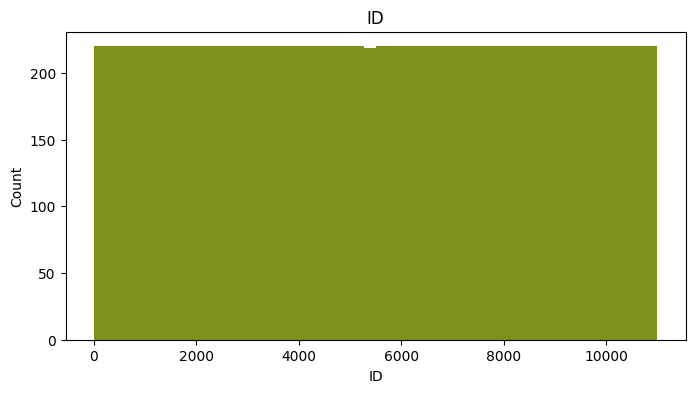

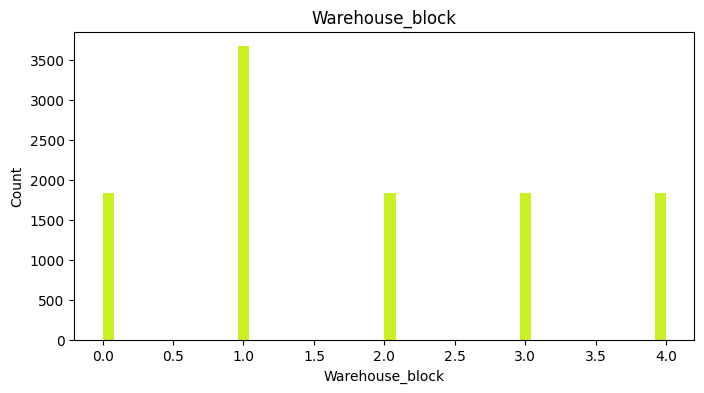

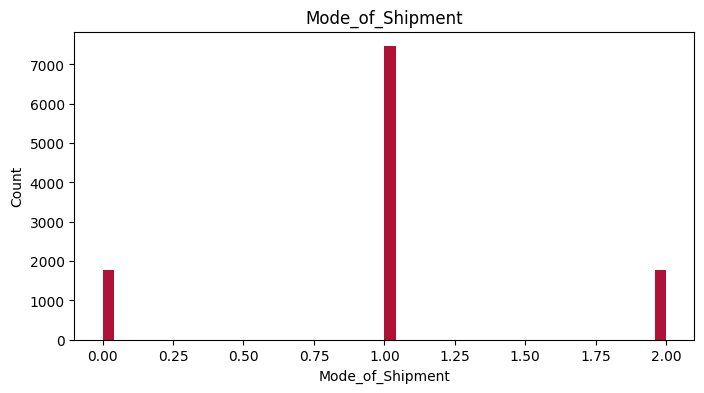

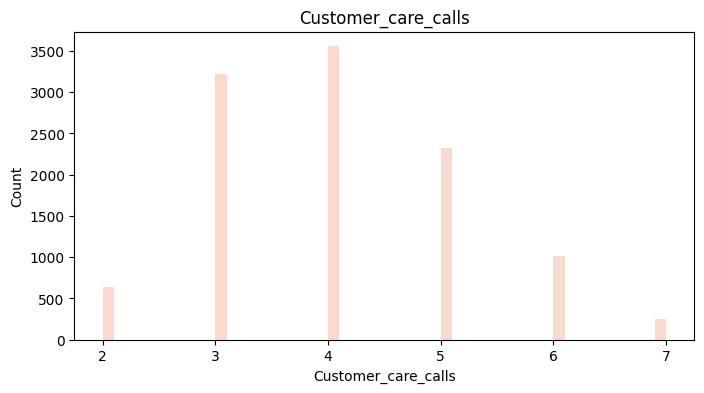

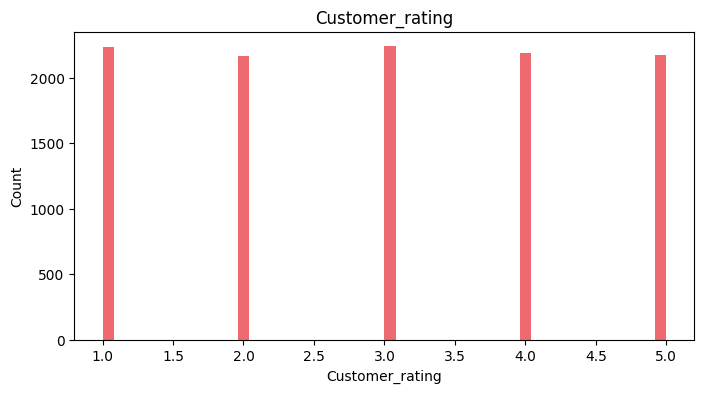

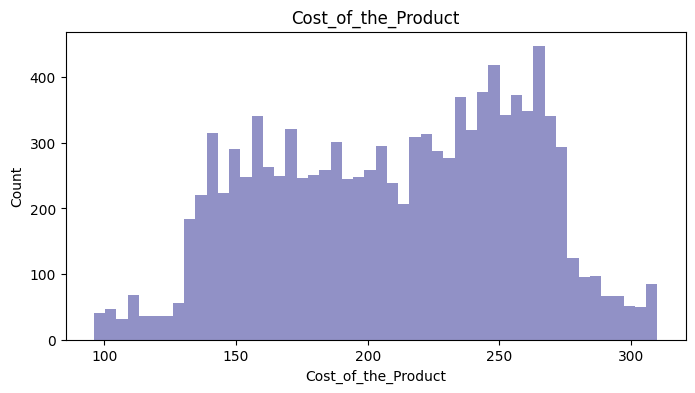

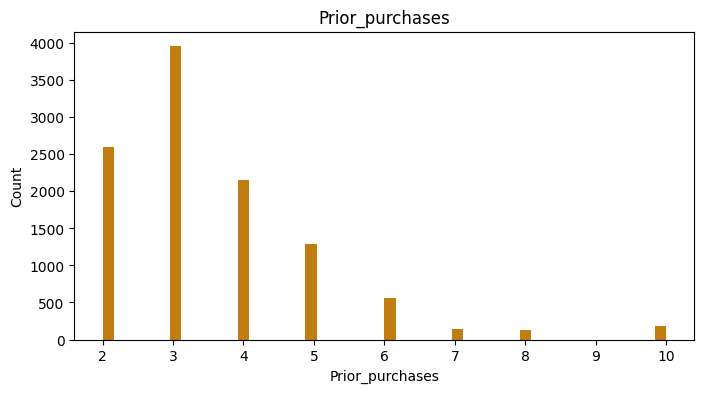

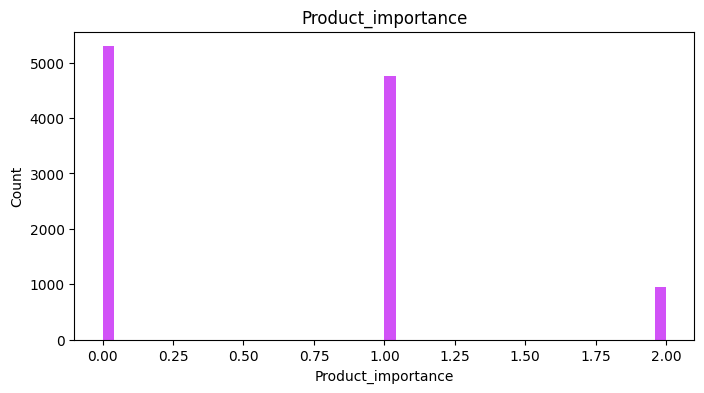

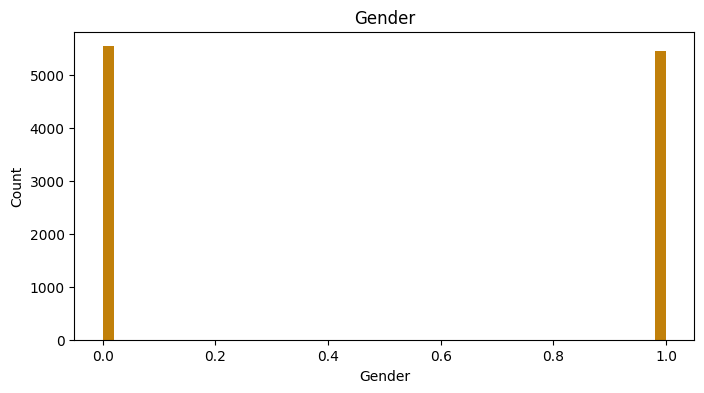

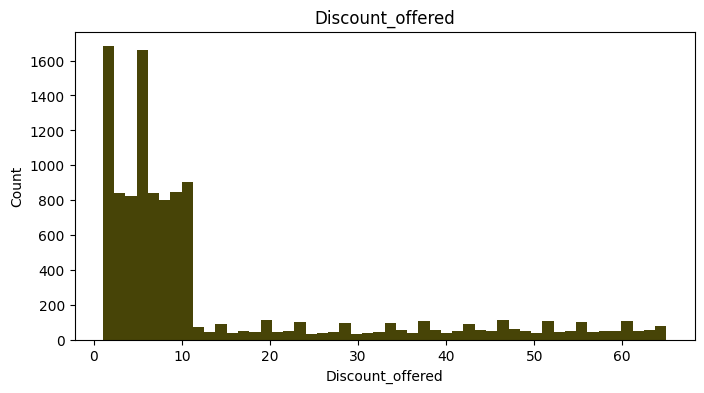

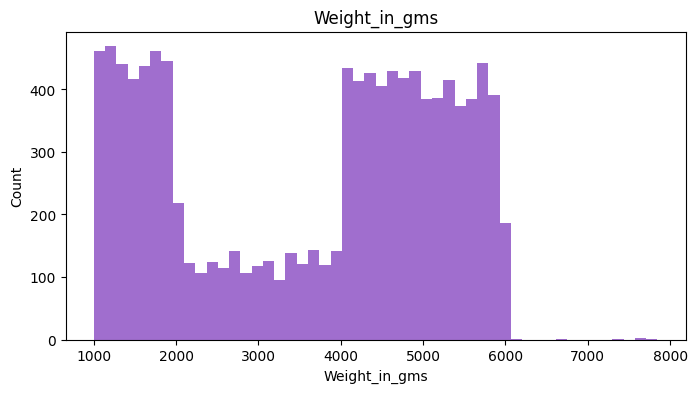

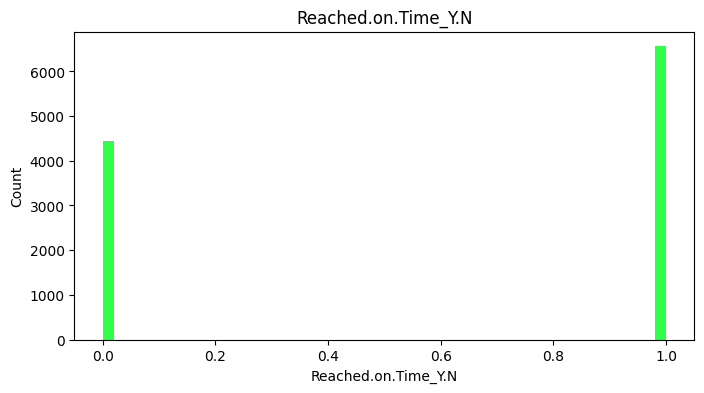

In [36]:
for column in data.columns:
         random_color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
         plt.figure(figsize=(8, 4))
         plt.hist(data[column], bins=50, color=random_color)
         plt.title(f'{column}')  # Set the title
         plt.xlabel(column)  # Set the x-axis label
         plt.ylabel('Count')  # Set the y-axis label
         plt.show()  # Show the plot

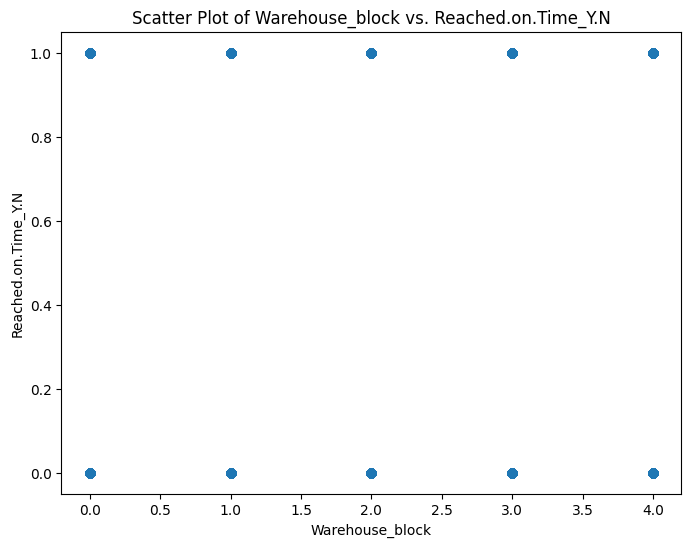

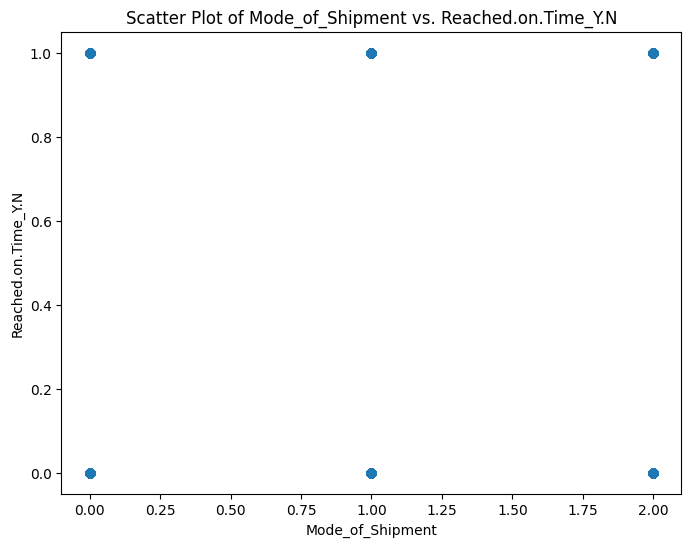

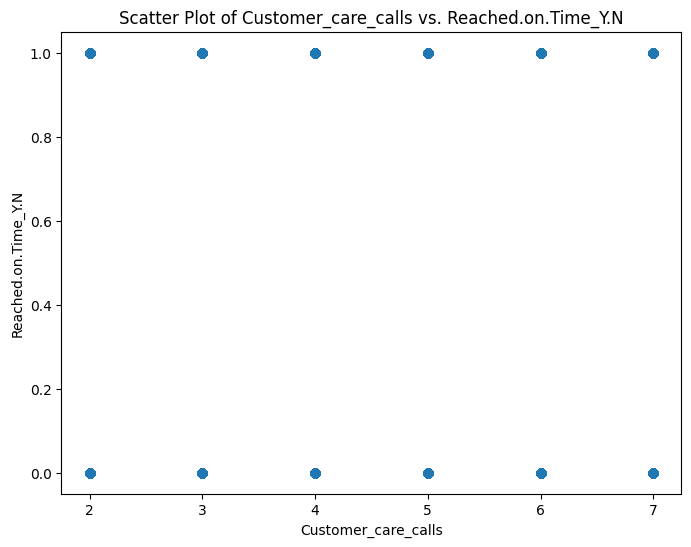

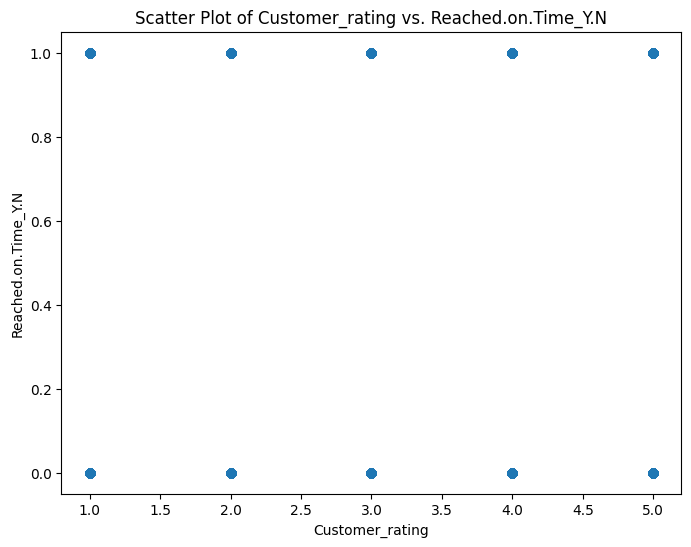

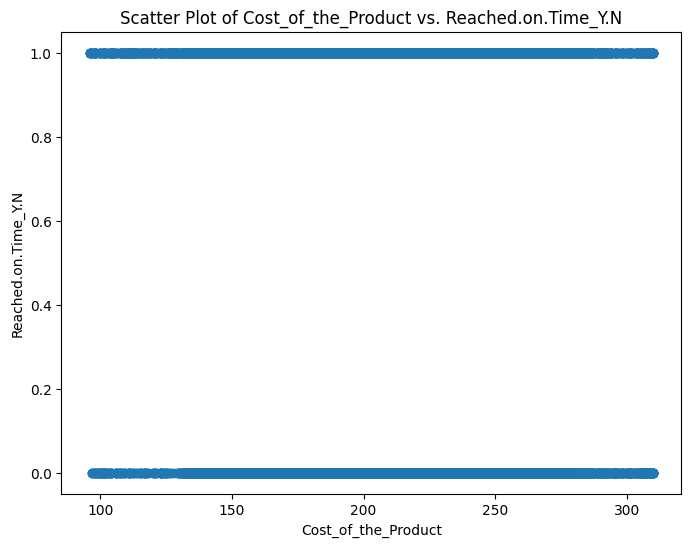

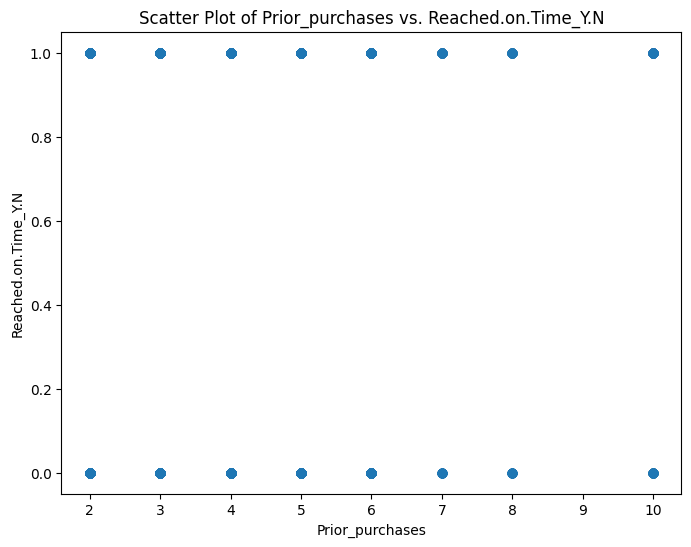

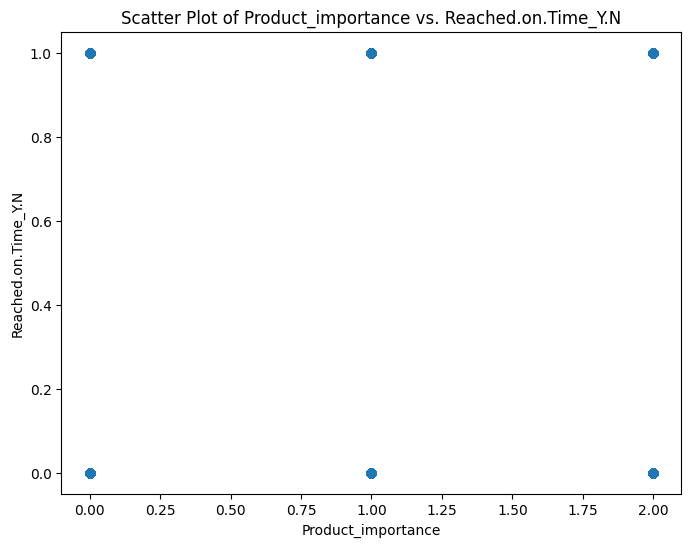

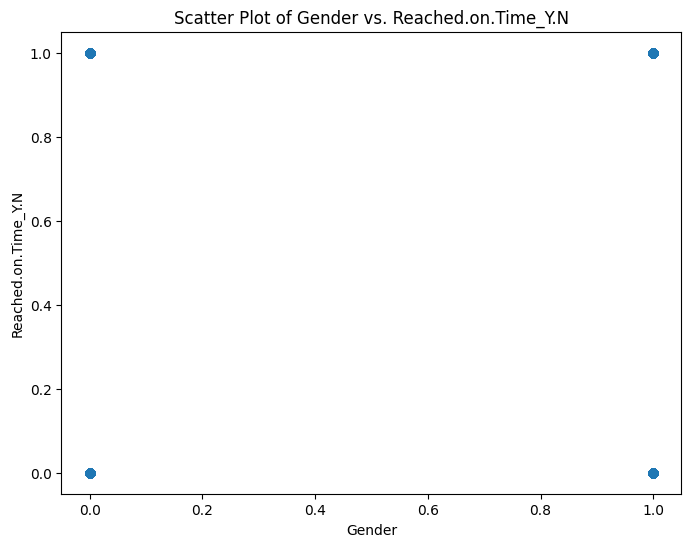

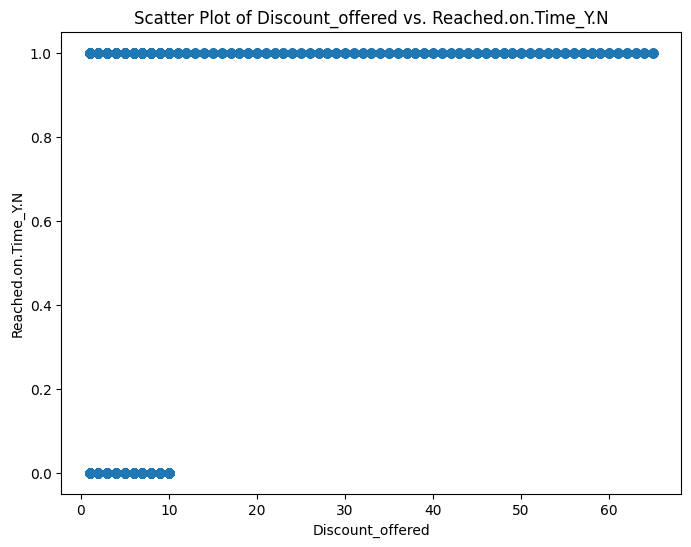

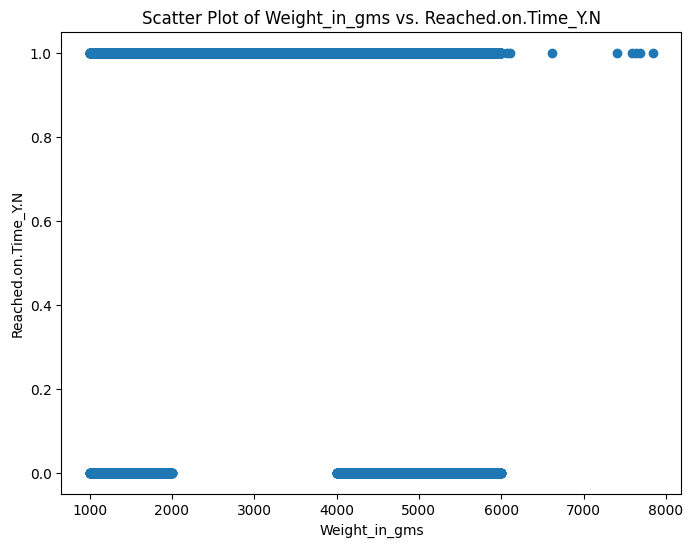

In [37]:
target_column = 'Reached.on.Time_Y.N'
column_to_skip = 'ID'
for column in data.columns:
    if column != target_column and column != column_to_skip:
        plt.figure(figsize=(8, 6))
        plt.scatter(data[column], data[target_column])
        plt.title(f'Scatter Plot of {column} vs. {target_column}')
        plt.xlabel(column)
        plt.ylabel(target_column)
        plt.show()

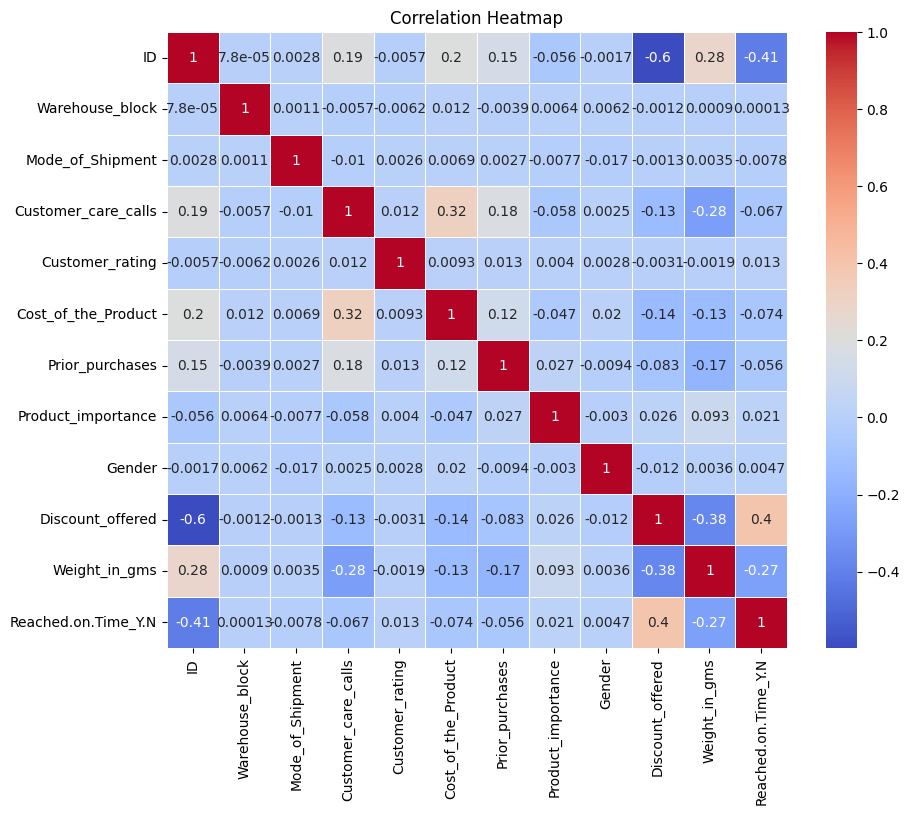

In [38]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [39]:
x = data[['Discount_offered','Weight_in_gms']]
y = data['Reached.on.Time_Y.N']

x_train, x_test, y_train, y_test = train_test_split(x,y,
                                        random_state=1234,test_size = 0.10,
                                        shuffle=True
                                        )
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(9899, 2)
(1100, 2)
(9899,)
(1100,)


In [40]:
scaler = StandardScaler()
x_train_standardized = scaler.fit_transform(x_train)
x_test_standardized = scaler.transform(x_test)

In [41]:
from sklearn.preprocessing import StandardScaler

def models_eval_mm(x_train, y_train, x_test, y_test):

    # Logistic Regression
    lg = LogisticRegression(random_state=1234)
    lg.fit(x_train_standardized, y_train)
    print("--Logistic Regression--")
    print("Train Score:", lg.score(x_train_standardized, y_train))
    print("Test Score:", lg.score(x_test_standardized, y_test))
    print()

    # Logistic Regression with Cross-Validation
    lcv = LogisticRegression(random_state=1234)
    lcv.fit(x_train_standardized, y_train)
    print("--Logistic Regression CV--")
    print("Train Score:", lcv.score(x_train_standardized, y_train))
    print("Test Score:", lcv.score(x_test_standardized, y_test))
    print()

    # XGBoost
    xgb = XGBClassifier(random_state=1234)
    xgb.fit(x_train_standardized, y_train)
    print("--XGBoost--")
    print("Train Score:", xgb.score(x_train_standardized, y_train))
    print("Test Score:", xgb.score(x_test_standardized, y_test))
    print()

    # Ridge Classifier
    rg = RidgeClassifier(random_state=1234)
    rg.fit(x_train_standardized, y_train)
    print("--Ridge Classifier--")
    print("Train Score:", rg.score(x_train_standardized, y_train))
    print("Test Score:", rg.score(x_test_standardized, y_test))
    print()

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(x_train_standardized, y_train)
    print("--KNN--")
    print("Train Score:", knn.score(x_train_standardized, y_train))
    print("Test Score:", knn.score(x_test_standardized, y_test))
    print()

    # Random Forest
    rf = RandomForestClassifier(random_state=1234)
    rf.fit(x_train_standardized, y_train)
    print("--Random Forest--")
    print("Train Score:", rf.score(x_train_standardized, y_train))
    print("Test Score:", rf.score(x_test_standardized, y_test))
    print()

    # Support Vector Machine (SVM)
    svc = svm.SVC(random_state=1234)
    svc.fit(x_train_standardized, y_train)
    print("--SVM Classifier--")
    print("Train Score:", svc.score(x_train_standardized, y_train))
    print("Test Score:", svc.score(x_test_standardized, y_test))
    print()

    return lg, lcv, xgb, rg, knn, rf, svc


In [42]:
lg,lcv,xgb,rg,knn,rf,svc =  models_eval_mm(x_train_standardized,y_train,x_test_standardized,y_test)

--Logistic Regression--
Train Score: 0.6323871098090716
Test Score: 0.6381818181818182

--Logistic Regression CV--
Train Score: 0.6323871098090716
Test Score: 0.6381818181818182

--XGBoost--
Train Score: 0.7552278007879584
Test Score: 0.65

--Ridge Classifier--
Train Score: 0.6544095363167997
Test Score: 0.6518181818181819

--KNN--
Train Score: 0.7738155369229215
Test Score: 0.6581818181818182

--Random Forest--
Train Score: 0.9582786140014142
Test Score: 0.6027272727272728

--SVM Classifier--
Train Score: 0.670875846045055
Test Score: 0.66



In [43]:
# Logistic Regression
lg_prediction = lg.predict(x_test.iloc[0].values.reshape(1, -1))
print("Logistic Regression Prediction:", lg_prediction)

# Logistic Regression with Cross-Validation
lcv_prediction = lcv.predict(x_test.iloc[0].values.reshape(1, -1))
print("Logistic Regression with Cross-Validation Prediction:", lcv_prediction)

# XGBoost
xgb_prediction = xgb.predict(x_test.iloc[0].values.reshape(1, -1))
print("XGBoost Prediction:", xgb_prediction)

# Ridge Classifier
rg_prediction = rg.predict(x_test.iloc[0].values.reshape(1, -1))
print("Ridge Classifier Prediction:", rg_prediction)

# K-Nearest Neighbors
knn_prediction = knn.predict(x_test.iloc[0].values.reshape(1, -1))
print("K-Nearest Neighbors Prediction:", knn_prediction)

# Random Forest
rf_prediction = rf.predict(x_test.iloc[0].values.reshape(1, -1))
print("Random Forest Prediction:", rf_prediction)

# Support Vector Machine (SVM)
svc_prediction = svc.predict(x_test.iloc[0].values.reshape(1, -1))
print("Support Vector Machine (SVM) Prediction:", svc_prediction)

Logistic Regression Prediction: [0]
Logistic Regression with Cross-Validation Prediction: [0]
XGBoost Prediction: [1]
Ridge Classifier Prediction: [0]
K-Nearest Neighbors Prediction: [1]
Random Forest Prediction: [1]
Support Vector Machine (SVM) Prediction: [1]


In [44]:
def evaluate_model(name, model, x_test, y_test):
    y_pred = model.predict(x_test_standardized)
    result = []
    result.append(name)
    result.append(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    result.append(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")
    result.append(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}%")
    result.append(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")
    return result

model_list = {
    "Logistic Regression": lg,
    "Logistic Regression CV": lcv,
    "XGBoost": xgb,
    "Ridge Classifier": rg,
    "KNN": knn,
    "Random Forest": rf,
    "Support Vector Classifier": svc
}

model_eval_info = []
for model_name, model in model_list.items():
    model_eval_info.append(evaluate_model(model_name, model, x_test_standardized, y_test))

model_eval_info = pd.DataFrame(model_eval_info, columns=["Name", "Accuracy", "F1 Score", "Recall", "Precision"])
model_eval_info.to_csv("model_eval.csv")

model_eval_info


,Name,Accuracy,F1 Score,Recall,Precision
0,Logistic Regression,Accuracy: 63.82%,F1 Score: 69.15%,Recall: 69.91%,Precision: 68.40%
1,Logistic Regression CV,Accuracy: 63.82%,F1 Score: 69.15%,Recall: 69.91%,Precision: 68.40%
2,XGBoost,Accuracy: 65.00%,F1 Score: 68.57%,Recall: 65.83%,Precision: 71.55%
3,Ridge Classifier,Accuracy: 65.18%,F1 Score: 68.79%,Recall: 66.14%,Precision: 71.65%
4,KNN,Accuracy: 65.82%,F1 Score: 70.53%,Recall: 70.53%,Precision: 70.53%
5,Random Forest,Accuracy: 60.27%,F1 Score: 66.77%,Recall: 68.81%,Precision: 64.84%
6,Support Vector Classifier,Accuracy: 66.00%,F1 Score: 67.36%,Recall: 60.50%,Precision: 75.98%


In [45]:
import pickle

In [46]:
filename="bestmodel.pkl"
pickle.dump(knn,open(filename,'wb'))

In [47]:
from sklearn.preprocessing import StandardScaler
scaler2=StandardScaler()

In [49]:
filename2="Scaler.pkl"
pickle.dump(scaler2,open(filename2,'wb'))